# Washington DC Crime Analysis

In [229]:
import urllib3
import certifi
import json
import pandas as pd

### Retrive Data for Project
For this project I began by retrieving a dataset from District of Columbias' REST API chronicalling details of crime as occurred 
between 1/1/2022 and 12/31/2022.

In [230]:
# handle certificate verification with certifi for security and retrieve API
http = urllib3.PoolManager(cert_reqs="CERT_REQUIRED", ca_certs=certifi.where())
url = "https://maps2.dcgis.dc.gov/dcgis/rest/services/FEEDS/MPD/MapServer/2/query?where=1%3D1&outFields=*&outSR=4326&f=json"
r = http.request("GET", url)
r.status

200

### Adapt Dataset 
Next we use the _json_ library to parse our JSON object and normalize it into a dataframe using _pandas_.


In [231]:
# decode data from API to dictionary and normalize dictionary into dataframe
data = json.loads(r.data.decode("utf-8"))
df = pd.json_normalize(data, "features")

### Initial Dataframe Transformation
Removal of null values, unnecessary columns, formatting headers, and classification of crimes as violent and non-violent are our main actions here. 

In [232]:
# Format Columns and add aggregation/Group Columns

df.dropna()
df.columns = df.columns.str.replace("attributes.", "").str.lower()
df["count"] = 1                                                          

df[["report_dat", "start_date", "end_date"]] = df[["report_dat", "start_date", "end_date"]].apply( 
    lambda x: pd.to_datetime(x, unit='ms').dt.date)                                     


df.drop(['ccn', 'yblock', 'xblock', 'anc', 'psa', 'bid', 'objectid', 
         'octo_record_id', 'geometry.x', 'geometry.y'], axis=1, inplace=True)

df['neighborhood_cluster'] = df['neighborhood_cluster'].str.extract('(\d+)').astype('Int64')

# Group Offense Type into Violent/Non-Violent 
df['offense_class'] = df['offense'].apply(                                          
    lambda x: 'Violent' if x in [
        'ASSAULT W/DANGEROUS WEAPON', 'SEX ABUSE' , 'HOMICIDE'] else 'Non-Violent')

df['offense'] = df['offense'].str.capitalize().replace({
    'Theft f/auto': 'Auto Theft', 'Theft/other': 'Petty Theft',
    'Assault w/dangerous weapon': 'Assualt'
    })


df['shift'] = df['shift'].str.capitalize()



### First Impressions
Group records by time of day and type of offense, We find night hours to be the most dangerous and that non violent crimes make up the majority of our crime during the sample period.

In [233]:
shift_agg = df.groupby(['shift', ])['count'].agg(['sum']).reset_index().rename(columns={
    'sum': "Number of Offenses", 'shift': "Time of Day"
    }).sort_values(by="Number of Offenses", ascending=False).style.set_properties(**{'text-align': 'left'})


offense_agg = df.groupby(['offense'])['count'].agg(['sum']).reset_index().rename(columns={
    'sum': "Count of Occurence", 'offense': "Type of Offense"
}).sort_values(by='Count of Occurence', ascending=False).style.set_properties(**{
    'text-align': 'left'})

table_style = [{'selector': 'th.col_heading', 'props': [('text-align', 'left')]}]

shift_agg.set_table_styles(table_style)
offense_agg.set_table_styles(table_style)


display(shift_agg)
display(offense_agg)

,Time of Day,Number of Offenses
1,Evening,455
0,Day,364
2,Midnight,181


,Type of Offense,Count of Occurence
6,Petty Theft,420
2,Auto Theft,289
5,Motor vehicle theft,117
7,Robbery,67
3,Burglary,49
1,Assualt,45
4,Homicide,7
8,Sex abuse,5
0,Arson,1


### Visualize relationships between Type of Crime and Time of Day
By applying our data to a stacked bar chart, we see that while our previous observations are correct, there is also no shortage of crime that occured during the day in the sample period. With __Petty Theft__ and __Auto Theft__ having large quatities of events occuring during daytime hours.

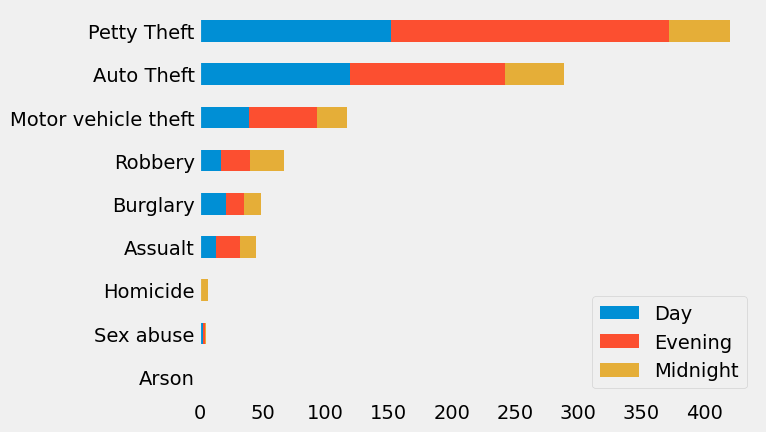

In [234]:
import pandas as pd
import matplotlib.pyplot as plt

df_group = df.groupby(['offense', 'shift']).agg({'count': 'sum'}).unstack()
df_group = df_group.loc[df_group.sum(axis=1).sort_values().index]

ax = df_group.plot(kind='barh', stacked=True, grid=False)

handles, labels = ax.get_legend_handles_labels()

new_lables = ['Day', 'Evening', 'Midnight']

ax.legend(handles, new_lables, loc='lower right', labelcolor='black')
ax.set_ylabel('')
plt.xticks(c='black')
plt.yticks(c='black')
plt.show()

### Analysis of Crime by Police District
Shifting focus, We begin to look at other areas of our data to see what _Police Districts_ might be higher risk by creating a heatmap. 

We see a disproportionate volumn of incidents in __District 3__. Most are non violent, yet we do see the _second highest number of homicides_ per district and the _highest number of sex abuse_ crimes of the sample period.

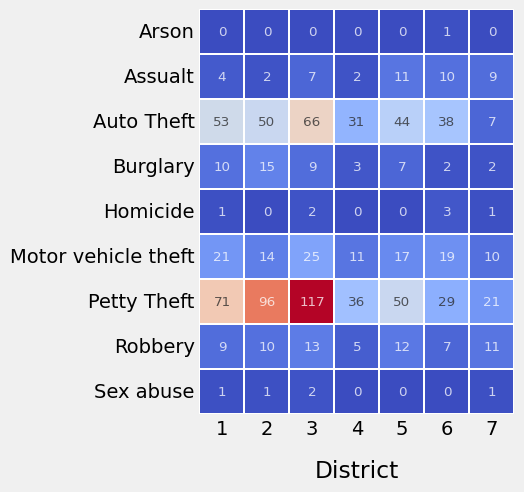

In [241]:
import seaborn as sns
import matplotlib.pyplot as plt

cross_tab = pd.crosstab(index=[ df['offense']], columns= df['district'])

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(cross_tab, annot=True, fmt='d',cmap="coolwarm", 
            cbar=False, square=True, linewidths=0.25, annot_kws={
                'size': 'x-small', 'alpha': 0.75
            })


plt.xlabel('District', labelpad=15, c='black')
plt.xticks(c='black')
plt.yticks(c='black')
plt.ylabel('')
plt.show()


### Police District Further Analysis
Let us examine __Violent Crime__ more closely, classifed as Homicide, Sexual Abuse, or Assualt. 

With __matplotlib__'s scatter plot we can create a psuedo map to visualize the density of violent crimes across the districts of the city. We see that the further south we view, the higher the concentration of Violent Crime events.

When directly comparing violent crime by district in a bar chart, it becomes clear that __Districts 6 & 7 are the most dangerous__ during the time shown in the sample period.

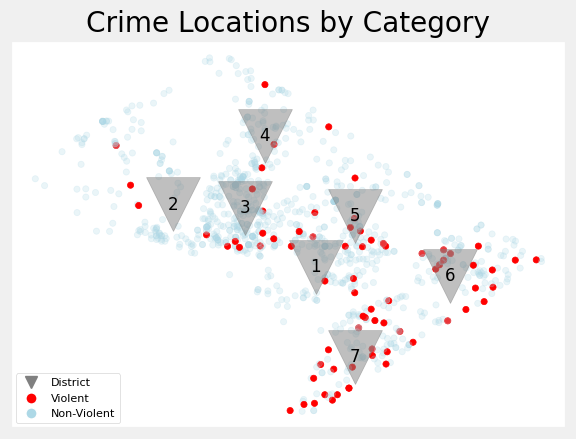

In [216]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# locate mean position for each district
district_coord_df = df.groupby('district')[['latitude', 'longitude']].mean()
district_lat = district_coord_df['latitude']
district_lon = district_coord_df['longitude']


color_map = {'Violent': 'red', 'Non-Violent': 'lightblue'} 
alpha_set = [0.25 if offense_class == 'Non-Violent' else 1.0  # contrast opacity for crime category
             for offense_class in df['offense_class']] 


fig = df.plot(kind='scatter', 
              x='longitude', y='latitude', c=df['offense_class'].map(color_map),
              alpha=alpha_set, grid=False)

fig.set(xlabel=None, ylabel=None)
fig.set_facecolor("white")


plt.scatter(district_lon, district_lat,  # overlay district locations
            marker='v', color='grey', s=1500, alpha=0.5)

for i, txt in enumerate(district_coord_df.index): # then annotate each district marker
    plt.annotate(txt, (district_lon[i], district_lat[i]), 
                 fontsize=12, ha='center', va='center', c='black')


# the following 3 code blocks organize the legend by both category and district annotation
annotations_legend_element = Line2D([0], [0], marker='v', color='grey', markerfacecolor='grey', markersize=8,
                                   linestyle='None', label='District')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[label], markersize=8,
                          label=label)
                   for label in color_map]

plt.legend(handles=[annotations_legend_element, *legend_elements], 
           title=False, facecolor='white', fontsize=8, loc='lower left', labelcolor='black')

plt.title("Crime Locations by Category", c='black')
plt.xticks([]) # make x,y ticks empty lists to remove the axis labeling
plt.yticks([])
plt.show()

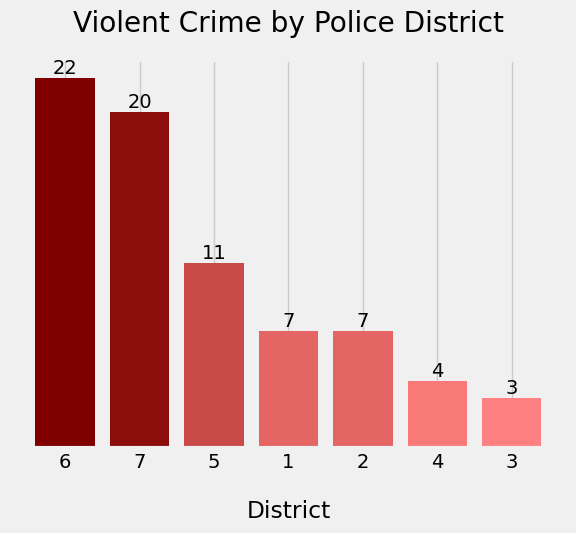

In [198]:
import numpy as np
import matplotlib as mp

block_df = df.loc[(df['offense_class']=='Violent')].groupby(
    ['district'])['count'].count().reset_index().sort_values(by='count', ascending=False)

x = block_df['district']
y = block_df['count']


grad = np.array(block_df['count'])  # Create array of sums to stage gradient color mapping
normalize = mp.colors.Normalize()   # normalize interval scale for gradient 
bar_col_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

N = len(block_df['count'])
x_nums = np.arange(1, N+1)


ax = plt.axes()
ax.set_facecolor('white')


'''
this creates the data labels for our column chart by iterating through our y values['count'] 
and placing that value on top of the bar
 '''
 
def addlabels(y): 
    for i, value in enumerate(y):
        plt.text(i, value, value, ha='center', va= 'bottom', c='black')

addlabels(y=y )

plt.style.use('fivethirtyeight')
fig = plt.bar(x=x, height=y, color=bar_col_map(normalize(grad)))
ax.set_facecolor('#f0f0f0')
plt.title("Violent Crime by Police District", pad=20, c='black')
plt.xlabel("District", labelpad=20, c='black')
plt.xticks(c='black')
plt.yticks([])
plt.show()

### Crime by Period Analysis

We now have a clear indication of _what_ crimes occurred and _where_ they happened.

Next let's shift our focus to __when things happened__.

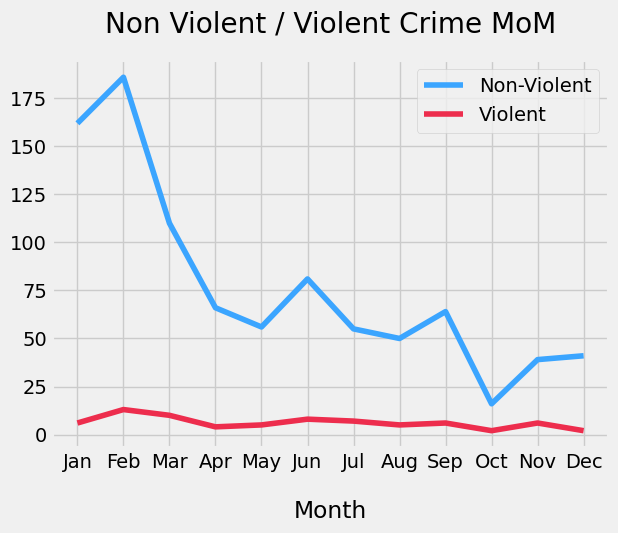

In [228]:
import calendar


df['month'] = df['report_dat'].astype('datetime64[ns]').dt.month
df['abbr_month'] = df['month'].apply(lambda x: calendar.month_abbr[x])

month_order = list(calendar.month_abbr)[1:]
df['abbr_month'] = pd.Categorical(df['abbr_month'], categories=month_order, ordered=True)


month_group = df.loc[(df['offense_class']=='Non-Violent')].groupby(     # Group Non
    ['abbr_month'])['count'].count().reset_index() 

month_group_violent = df.loc[(df['offense_class']=='Violent')].groupby(     # Group Violent
    ['abbr_month'])['count'].count().reset_index() 

x = month_group['abbr_month']
y = month_group['count']

v_x = month_group_violent['abbr_month']
v_y = month_group_violent['count']


plt.style.use('fivethirtyeight')
line_fig= plt.plot(x, y, c='#3ba5ff', label='Non-Violent')           # first fig for Non Violent Plot
v_line_fig= plt.plot(v_x, v_y, c='#ed2d4d', label='Violent')     # Second Fig for Violent Plot


legend = plt.legend()
legend.get_texts()[0].set_color('black')
legend.get_texts()[1].set_color('black')


plt.title("Non Violent / Violent Crime MoM", pad=20, c='black')
plt.xlabel("Month", labelpad=20, c='black')
plt.xticks(c='black')
plt.yticks(c='black')
plt.show()


We see a large volume of __non-violent__ crime at the beggining of the year, with an aggressive decrease through _March_ and _April_. The Based on the data available it is unclear what caused this sharp decrease. Unfortunately __Violent__ crime remains consistent throughout the year sampled

Upon further analysis we can see that __Sunday__ and __Monday__ account for the most prevelant days for criminal activity. 

Across the sample period we see an __average__ of 3 crimes committed per day.

In [282]:
from tabulate import tabulate

df['weekday'] = df['report_dat'].astype('datetime64[ns]').dt.strftime('%a')

group_wk_day = df.groupby(['weekday'])['count'].count().reset_index().sort_values(by='count', ascending=False)

print(tabulate(group_wk_day, headers='keys', tablefmt='psql'))

+----+-----------+---------+
|    | weekday   |   count |
|----+-----------+---------|
|  3 | Sun       |     168 |
|  1 | Mon       |     165 |
|  5 | Tue       |     144 |
|  0 | Fri       |     140 |
|  6 | Wed       |     134 |
|  4 | Thu       |     125 |
|  2 | Sat       |     124 |
+----+-----------+---------+


In [295]:
total_crime_count = df['count'].sum()

avg_crime_by_day = total_crime_count / len(df['report_dat'].unique())

avg_rounded = round(avg_crime_by_day)

print(f"Average Daily Crime Count: {avg_rounded}") 

Average Daily Crime Count: 3


## Conclusions

During this analysis, we have explored the crime landscape within the District of Columbia using various dimensions and levels of granularity. Our findings reveal that the majority of incidents during the sample period were categorized as __non-violent crimes__. These crimes tended to occur in the __evening__, particularly towards the __end of the weekend__ or the __beginning of the work week__.

Furthermore, our analysis provided insights into the geographic distribution of these crimes. As we moved __southeast__ within the city, the likelihood of encountering such events increased. This _indicates a concentration of non-violent crimes in that region_.

Overall, this project served as an excellent opportunity to practice data analysis, storytelling through visualization, and data processing in JSON. It deepened our understanding of crime patterns in the District of Columbia and highlighted the importance of considering various dimensions when studying criminal activity.